In [1]:
import networkx as nx
from networkx.algorithms import approximation as approx
from networkx.algorithms import shortest_path
import random
import numpy as np
import matplotlib.pyplot as plt

Implementing CNOT circuit synthesis algorithm in the paper https://iopscience.iop.org/article/10.1088/2058-9565/ab79b1 and comparing to naive method.

In [2]:
def draw_graph(G, S=[]):
    # draws, and highlights S
    colours = ['limegreen' if n in S else 'royalblue' for n in list(G.nodes)]
    nx.draw(G, node_color=colours, with_labels=True, font_color='black')

def E(M, i, j, k=-1, message='forbidden'):
    # add row i to row j (CNOTji)
    assert i != j
    if i < k:
        print(message)
    M[j] = (M[i]+M[j])%2
    return M

def SWAP(M, i, j):
    # SWAP gate = 3 CNOTs
    temp = M[i]
    M[i] = M[j]
    M[j] = temp
    return M

def create_M(n):
    # Creates invertible F2 matrix
    M = np.zeros((n,n))
    while np.isclose(np.linalg.det(M)%2, 0, atol=1e-1) or np.isclose(np.linalg.det(M)%2, 2, atol=1e-1):
        M = np.random.randint(0, 2, size=(n,n))
    test = np.linalg.inv(M)
    return M

def G_to_nums(G, rev=False):
    # Relabels or reverses order of nodes
    n = G.number_of_nodes()
    nodes = list(G.nodes)
    dic = {nodes[i]:i for i in range(n)}
    if rev:
        {nodes[i]:n-1-i for i in range(n)}
    return nx.relabel_nodes(G, dic)

def create_G(n, p=0.1):
    # Create connected graph 
    # sparseness p (probability of edge)
    G = nx.fast_gnp_random_graph(n,p)
    G = G_to_nums(G)
    G.add_edges_from([(i,i+1) for i in range(n-1)])
    return G

def create_S(G, M, k):
    # terminals S is the rows j with M_jk=1
    column = M[:, k]
    n = len(column)
    nodes = list(G.nodes)
    S = [i for i in range(k, n)  
         if column[i]==1]
    assert k in S
    return S

def create_T(G, S, k):
    # Steiner tree on row k with terminals S
    vertices = list(range(k,n))
    H = nx.induced_subgraph(G, vertices)
    T = approx.steiner_tree(H, S).copy()
    if len(T.nodes())==0:
        T.add_node(S[0])
    return T


In [123]:
def bubble_up(G, M, i, silent=True):
    # puts a 1 in the (i,i) position of M
    # returns M, CNOT_count
    n = M.shape[0]
    CNOT_count = 0
    if M[i, i] == 1:
        return M, CNOT_count
    # search for closest 1
    sources = [j for j in range(i,n) if M[j,i]==1]
    vertices = list(range(i,n))
    H = nx.induced_subgraph(G, vertices)
    paths = nx.shortest_path(H, target=i)
    min_d = np.inf
    path = []
    for source in paths:
        d = len(paths[source])
        if d < min_d and source in sources:
            min_d = d
            path = paths[source]
    # apply operations
    if not silent:
        print(path)
    for j in range(len(path)-1):
        if not silent:
            print('CNOT', path[j], path[j+1])
        M = E(M,path[j],path[j+1],i, 'bubble error')
    CNOT_count += len(path)-1
    if not len(sources) > 0:
        print('source error')
    assert len(sources) > 0
    assert M[path[0],i]==1
    assert M[i,i]==1
    return M, CNOT_count


def tree_eliminate(T, M, k, silent=True):
    # assume all nodes are marked, root k
    # CNOT eliminate all nodes starting with leaves
    # returns M
    M = np.copy(M)
    queue = [k]
    visited_nodes = []
    operations = []
    while len(queue) > 0:
        curr = queue.pop()
        visited_nodes.append(curr)
        visit = [node for node in T.adj[curr] if 
                node not in visited_nodes]
        operations = [(curr,nxt) for nxt in visit] + operations
        queue += visit
    if not silent:
        print('eliminating tree')
    for i, j in operations:
        if not silent:
            print('CNOT',i,j)
        assert i!=j
        assert M[j,k]*M[i,k] == 1
        M = E(M, i, j, k, 'tree error')
    return M

def BFS_eliminate(T, S, M, k, silent=True):
    # Algorithm 2, on first pass of Algorithm 1
    # returns M, CNOT_count
    M = np.copy(M)
    CNOT_count = T.number_of_nodes()-len(S) + T.number_of_edges()
    marked_nodes = S.copy() # marked nodes
    assert k in S
    queue = [k] # BFS
    visited_nodes = [] # BFS
    operations = []
    while len(queue) > 0:
        curr = queue.pop()
        visited_nodes += [curr]
        visit = [node for node in T.neighbors(curr) if 
                node not in visited_nodes]
        unmarked = [node for node in visit if
                   node not in marked_nodes]
        queue += visit
        operations += [(curr, target) for target in unmarked]
        marked_nodes += unmarked
    
    if not silent:
        print('filling tree')
    # apply operations
    for i, j in operations:
        if not silent:
            print('CNOT',i,j)
        M = E(M, i, j, k, 'bfs error')
    # eliminate tree
    M = tree_eliminate(T, M, k, silent)
    return M, CNOT_count

In [124]:
def add_path(P, M):
    # adds the root to everything else on the path
    # returns M, CNOT_count
    if len(P) <= 1:
        return M, P
    if len(P) == 2:
        return E(M, P[0], P[1]), 1
    for j in range(len(P)-2, -1, -1):
        M = E(M, P[j], P[j+1])
    for j in range(1, len(P)-1):
        M = E(M, P[j], P[j+1])
    return M, 2*len(P)-3

def tree_eliminate1(T, M, k, c):
    # in column c of M
    # root k in T, root is smallest element
    # eliminate everything except k
    # returns M, CNOT_count
    if len(list(T.nodes)) <= 1:
        return M, 0
    
    CNOT_count, count = 0, 0
    nodes1 = list(T.nodes)
    nodes1.remove(k)
    
    while len(nodes1)>0:
        k1 = min(nodes1) # minimum element
        P = nx.shortest_path(T, k, k1)
        if M[k1, c] != 1: # need to fill the root k1
            M, count = add_path(P, M)
        assert M[k1, c] == 1
        CNOT_count += count
        
        # subtree with root k1
        T1 = T.copy()
        T1.remove_edge(P[-2],P[-1])
        subnodes = nx.node_connected_component(T1, k1)
        T1 = nx.induced_subgraph(T1, subnodes)
        # recursion
        M, count = tree_eliminate1(T1, M, k1, c)
        CNOT_count += count
        M, count = add_path(P, M)
        CNOT_count += count
        nodes1 = [node for node in nodes1 if node not in subnodes]
    return M, CNOT_count


def M_eliminate(G, M, silent=True):
    # Algorithm 1 main algorithm
    # Applies CNOTs to turn M into identity
    # returns M, CNOT_count
    M = np.copy(M)
    # Turns M upper triangular
    n = M.shape[0]
    CNOT_count = 0
    for k in range(n):
        M, CNOTs = bubble_up(G, M, k)
        CNOT_count += CNOTs
        S = create_S(G, M, k)
        T = create_T(G, S, k)
        M, CNOTs = BFS_eliminate(T, S, M, k)
        CNOT_count += CNOTs
    # transpose
    M = M.T
    G = G_to_nums(G, True)
    for k in range(n):
        S = create_S(G, M, k)
        T = create_T(G, S, k)
        M, CNOTs = tree_eliminate1(T, M, k, k)
    if not silent:
        print('done')
    # correctness
    assert np.allclose(M, np.identity(n))
    return M, CNOT_count

Example of the main algorithm `M_eliminate` running one iteration on a grid graph.

[[0 0 0 1 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 1]
 [1 0 1 0 0 1 0 1 1]
 [0 0 0 1 0 0 1 0 1]
 [0 1 1 1 1 0 1 1 1]
 [0 1 0 0 1 1 0 1 0]
 [1 1 1 1 0 1 1 0 1]
 [0 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 1 1 1]]


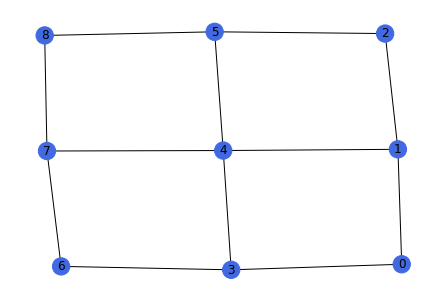

In [125]:
n = 9
# M is 9x9 invertible 
M = np.array([[0, 0, 0, 1, 1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 0, 0, 1, 0, 1, 1],
 [0, 0, 0, 1, 0, 0, 1, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 1, 1],
 [0, 1, 0, 0, 1, 1, 0, 1, 0],
 [1, 1, 1, 1, 0, 1, 1, 0, 1],
 [0, 1, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 0, 0, 1, 1, 1]])

np.linalg.inv(M)
# 3x3 grid graph
G = nx.grid_graph((3,3))
G = G_to_nums(G)
print(M)
draw_graph(G)

[6, 3, 0]
CNOT 6 3
CNOT 3 0
[[1 1 1 1 1 1 1 0 1]
 [0 1 0 1 0 1 0 1 1]
 [1 0 1 0 0 1 0 1 1]
 [1 1 1 0 0 1 0 0 0]
 [0 1 1 1 1 0 1 1 1]
 [0 1 0 0 1 1 0 1 0]
 [1 1 1 1 0 1 1 0 1]
 [0 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 1 1 1]]


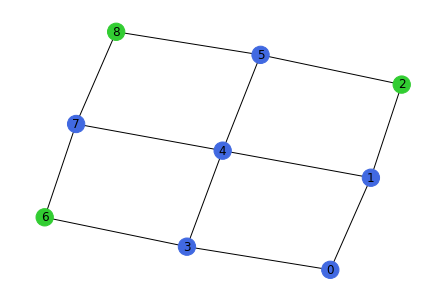

In [126]:
k = 0 # First column
S = [i for i in range(n) if M[i,k]==1]
draw_graph(G, S) # draw graph, highlighting terminals

M1 = np.copy(M)
# Now we need a 1 on the diagonal, so we have to bubble up the closest 1
# bubble_up chooses the 1 at 6, with path [6,3,0], so 
# CNOT(6,3), CNOT(3,0) gets applied 
M, _ = bubble_up(G, M, k, False)
print(M) # Now we can see we have a 1 on the diagonal

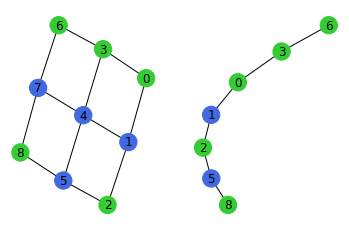

In [127]:
# Now we can create the Steiner tree
S = create_S(G, M, k) # Create terminals 
T = create_T(G, S, k) # Create Steiner tree

plt.subplot(121)
draw_graph(G, S)

plt.subplot(122)
draw_graph(T, S)

In [128]:
# Now lets see which operations BFS eliminate undergoes
M, _ = BFS_eliminate(T, S, M, k, False)
# We can see that 1 and 5 are Steiner nodes, and they get filled in by their parents in BFS eliminate
# starting from the root 0

# Next, T is filled, so the tree gets eliminated starting with the leaves CNOT(parent, leaf) and continues
# until only the root is left
print()
print(M)
# At the end only the 1 remains at the root (diagonal)

filling tree
CNOT 0 1
CNOT 2 5
eliminating tree
CNOT 3 6
CNOT 5 8
CNOT 2 5
CNOT 1 2
CNOT 0 3
CNOT 0 1

[[1 1 1 1 1 1 1 0 1]
 [0 1 0 1 0 1 0 1 1]
 [0 0 0 0 1 1 1 0 1]
 [0 0 0 1 1 0 1 0 1]
 [0 1 1 1 1 0 1 1 1]
 [0 1 0 0 1 1 0 1 0]
 [0 0 0 1 0 0 1 0 1]
 [0 1 0 0 0 1 1 0 0]
 [0 1 1 1 1 0 1 1 0]]


The above is an example of one iteration of our main algorithm, eliminating below-diagonal elements of the first column. This algorithm continues for the other columns, then transposes the matrix, repeating with the more intelligent `tree_eliminate1` algorithm.

Naive algorithm described in section 1.3

In [37]:
def SWAP_path(M, P):
    # SWAPs P[-1] until P[-1] and P[0] are adjacent
    # applies E(M, P[0], P[-1]) then swaps P[-1] back
    # CNOT count 2*(len(P)-2) SWAPs, 3 CNOTs per swap
    # 1 more E
    if len(P) <= 1:
        return M, 0
    M = E(M, P[0], P[-1])
    CNOT_count = 2*3*(len(P)-2)+1
    return M, CNOT_count
    
def SWAP_row_eliminate(G, M, k):
    # eliminates a row of M through SWAPs
    S = create_S(G, M, k)
    CNOT_count = 0
    for s in S:
        P = nx.shortest_path(G, k, s)
        M, count = SWAP_path(M, P)
        CNOT_count += count
    return M, CNOT_count
    
def SWAP_eliminate(G, M, silent=False):
    # Turns M upper triangular with SWAP method
    M = np.copy(M)
    n = M.shape[0]
    CNOT_count = 0
    for k in range(n):
        M, count = bubble_up(G, M, k)
        CNOT_count += count
        M, count = SWAP_row_eliminate(G, M, k)
        CNOT_count += count
    M = M.T
    for k in range(n):
        M, count = bubble_up(G, M, k)
        CNOT_count += count
        M, count = SWAP_row_eliminate(G, M, k)
        CNOT_count += count
    if not silent:
        print('done')
    # correctness 
    assert np.allclose(M, np.identity(n))
    return M, CNOT_count
    

Benchmark comparisons between SWAP and Steiner Tree method

Comparing CNOT count by number of qubits. Sparseness = 0.4

In [38]:
avgTREE = []
avgSWAP = []
diff = []
repeat = 10
# sometimes gives error for large matrices 
# determinant calculation sometimes produces floating point errors
ns = list(range(5, 45, 5)) 

for n in ns:
    print(n)
    sumTREE = 0
    sumSWAP = 0
    for k in range(repeat):
        M = create_M(n)
        G = create_G(n, 0.4)
        M0, swap = SWAP_eliminate(G, M, True)
        M1, tree = M_eliminate(G, M, True)
        sumTREE += tree
        sumSWAP += swap
    sumTREE /= repeat
    sumSWAP /= repeat
    diff.append(sumSWAP/sumTREE)
    avgTREE.append(sumTREE)
    avgSWAP.append(sumSWAP)

5
10
15
20
25
30
35
40


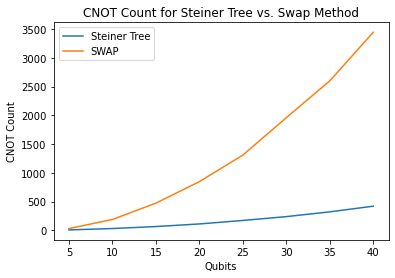

In [39]:
plt.plot(ns, avgTREE, label='Steiner Tree')
plt.plot(ns, avgSWAP, label='SWAP')

plt.xlabel('Qubits')
plt.ylabel('CNOT Count')
plt.title('CNOT Count for Steiner Tree vs. Swap Method')
plt.legend()
plt.show()

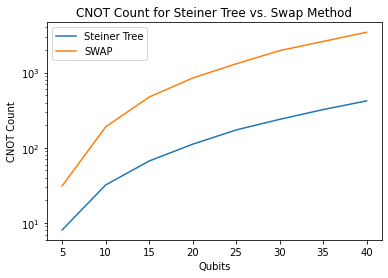

In [40]:
plt.plot(ns, avgTREE, label='Steiner Tree')
plt.plot(ns, avgSWAP, label='SWAP')

plt.xlabel('Qubits')
plt.ylabel('CNOT Count')
plt.yscale('log')
plt.title('CNOT Count for Steiner Tree vs. Swap Method')
plt.legend()
plt.show()

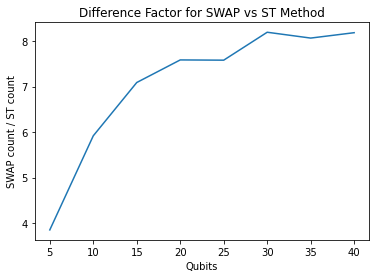

In [41]:
plt.plot(ns, diff)
plt.xlabel('Qubits')
plt.ylabel('SWAP count / ST count')
plt.title('Difference Factor for SWAP vs ST Method')
plt.show()

Comparing CNOT count by sparseness. qubits = 10

In [42]:
avgTREE = []
avgSWAP = []
diff = []
repeat = 100
n = 10
sparses = np.arange(0.04, 1.0001, 0.04)
for sparse in sparses:
    print(sparse)
    sumTREE = 0
    sumSWAP = 0
    for k in range(repeat):
        M = create_M(n)
        G = create_G(n, sparse)
        M0, swap = SWAP_eliminate(G, M, True)
        M1, tree = M_eliminate(G, M, True)
        sumTREE += tree
        sumSWAP += swap
    sumTREE /= repeat
    sumSWAP /= repeat
    diff.append(sumSWAP/sumTREE)
    avgTREE.append(sumTREE)
    avgSWAP.append(sumSWAP)

0.04
0.08
0.12
0.16
0.2
0.24000000000000002
0.27999999999999997
0.32
0.36
0.39999999999999997
0.44
0.48
0.52
0.56
0.6000000000000001
0.64
0.68
0.7200000000000001
0.76
0.8
0.8400000000000001
0.88
0.92
0.9600000000000001
1.0


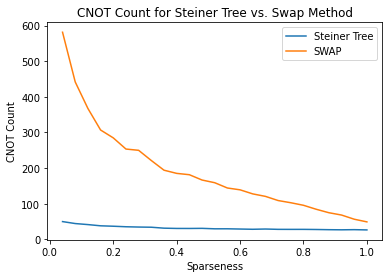

In [43]:
plt.plot(sparses, avgTREE, label='Steiner Tree')
plt.plot(sparses, avgSWAP, label='SWAP')
plt.xlabel('Sparseness')
plt.ylabel('CNOT Count')
plt.title('CNOT Count for Steiner Tree vs. Swap Method')
plt.legend()
plt.show()

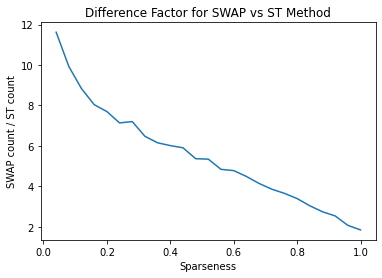

In [46]:
plt.plot(sparses, diff)
plt.xlabel('Sparseness')
plt.ylabel('SWAP count / ST count')
plt.title('Difference Factor for SWAP vs ST Method')
plt.show()